<h1 style="text-align:center; font-family:Arial, sans-serif; color:green; font-weight:bold; font-size:36px; margin-top:40px;">
   Social Media Engagement Dataset
</h1>

### <span style="color:green">Business Context</span> 
> Which platforms generate the most engagement

> What types of posts attract the strongest reactions.

> Whether sentiment (positive, negative, neutral) impacts engagement.

> How posting time and day affect user interaction.
</h2>

### <span style="color:green">Project Objectives</span> 
> Discover which platforms and post types consistently drive higher engagement

> Analyze how sentiment, posting time, and post length influence user behavior

> Build a predictive model that estimates engagement using post features

> Provide clear, data-driven recommendations to improve client performance

> Help the agency refine content strategy to increase reach and audience interaction
</h2>


### <span style="color:green">Challenge</span>

> As the analyst, you are responsible for:
> Cleaning and preparing the dataset for analysis

> Engineering new features (e.g., total engagement, post length, posting patterns)

> Visualizing trends across platforms, post types, and sentiment levels

> Training and evaluating machine learning models that predict engagement


# Step 0: Setup Kaggle API

In [331]:
!pip install kaggle --quiet

import os

# Set your Kaggle credentials (replace with your own)
os.environ['KAGGLE_USERNAME'] = "YOUR_KAGGLE_USERNAME"
os.environ['KAGGLE_KEY'] = "YOUR_REAL_KEY"

# Create data folder
os.makedirs('./data', exist_ok=True)


Step 1: Download and unzip the dataset

In [334]:
# -----------------------------
# 1️⃣ Download and Unzip Dataset from Kaggle
# -----------------------------
!kaggle datasets download -d divyaraj2006/social-media-engagement -p ./data --unzip

# Check files
print("Files in ./data folder:", os.listdir('./data'))


Dataset URL: https://www.kaggle.com/datasets/divyaraj2006/social-media-engagement
License(s): apache-2.0

Files in ./data folder: ['social_media_engagement1.csv']



  0%|          | 0.00/2.09k [00:00<?, ?B/s]
100%|##########| 2.09k/2.09k [00:00<?, ?B/s]


Step 2: Load the dataset

In [215]:
# -----------------------------
# 2️⃣ Load Dataset
# -----------------------------
import pandas as pd

# Replace with actual filename from Kaggle download
df = pd.read_csv('./data/social_media_engagement1.csv')
df_use = df

# Inspect dataset structure, types, missing values
# Ensures dataset loaded correctly and we understand column types and sample data.

print(df_use.info())
print("Dataset Shape:", df_use.shape)
print("Columns:", df_use.columns)
print(df_use.head())

print(df_use.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   post_id          100 non-null    int64 
 1   platform         100 non-null    object
 2   post_type        100 non-null    object
 3   post_time        100 non-null    object
 4   likes            100 non-null    int64 
 5   comments         100 non-null    int64 
 6   shares           100 non-null    int64 
 7   post_day         100 non-null    object
 8   sentiment_score  100 non-null    object
dtypes: int64(4), object(5)
memory usage: 7.2+ KB
None
Dataset Shape: (100, 9)
Columns: Index(['post_id', 'platform', 'post_type', 'post_time', 'likes', 'comments',
       'shares', 'post_day', 'sentiment_score'],
      dtype='object')
   post_id   platform post_type        post_time  likes  comments  shares  \
0        1   Facebook     image  8/17/2023 14:45   2121       474     628   
1        2  

Step 3: Basic Cleaning

In [115]:
# -----------------------------
# 3️⃣ Data Cleaning
# Prepares data for analysis by removing duplicates and nulls.
# Ensures categorical columns are ready for one-hot encoding.
# -----------------------------
# Remove duplicate rows
df = df.drop_duplicates()

# Remove rows with missing values to avoid errors in analysis
df = df.dropna()

# Identify categorical columns automatically
categorical_cols = [col for col in df.select_dtypes(include=['object']).columns]
print("Categorical columns detected:", categorical_cols)

# Convert all object-type columns to string (ensures proper encoding later)
for col in categorical_cols:
    df[col] = df[col].astype(str)


Categorical columns detected: ['platform', 'post_type', 'post_time', 'post_day', 'sentiment_score']


In [179]:
df['Total_Engagement'] = df['likes'] + df['comments'] + df['shares']
print(df['Total_Engagement'].head())


0    3223
1    4786
2    6051
3    1460
4    4032
Name: Total_Engagement, dtype: int64


In [225]:
# -----------------------------
# Social Media Engagement Analysis
# This script explores which factors drive engagement (likes, comments, shares)
# across platforms, post types, sentiment, posting time, and day of week.
# -----------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# -----------------------------
# 1️⃣ Load / Reuse Data
# If df_social exists, use it; otherwise, load CSV
try:
    df_use = df_social.copy()
except Exception:
    df_use = pd.read_csv('./data/social_media_engagement1.csv')

# -----------------------------
# 2️⃣ Basic Cleaning & Feature Engineering
analysis_df = df_use.copy()

# Standardize column names: lowercase and strip spaces
analysis_df.columns = [str(c).strip().lower() for c in analysis_df.columns]

# Convert post_time to datetime; coerce errors to NaT
analysis_df['post_time'] = pd.to_datetime(analysis_df['post_time'], errors='coerce')

# Ensure numeric columns for engagement metrics
for col in ['likes', 'comments', 'shares']:
    analysis_df[col] = pd.to_numeric(analysis_df[col], errors='coerce')

# Create a total engagement metric
analysis_df['total_engagement'] = analysis_df[['likes','comments','shares']].sum(axis=1)

# Extract posting hour, day of week, month, and weekend indicator
analysis_df['post_hour'] = analysis_df['post_time'].dt.hour
analysis_df['post_dow'] = analysis_df['post_time'].dt.day_name()
analysis_df['post_month'] = analysis_df['post_time'].dt.month
analysis_df['is_weekend'] = analysis_df['post_time'].dt.dayofweek.isin([5,6]).astype('int64')

# Standardize sentiment score
analysis_df['sentiment_score'] = analysis_df['sentiment_score'].astype(str).str.strip().str.lower()

In [227]:
# -----------------------------
# 3️⃣ Aggregations for EDA
# Compute average and median engagement metrics by platform, post type, sentiment, hour, and day

# Platform-level summary
platform_summary = analysis_df.groupby('platform', dropna=False).agg(
    n_posts=('post_id','count'),
    avg_total_engagement=('total_engagement','mean'),
    median_total_engagement=('total_engagement','median'),
    avg_likes=('likes','mean'),
    avg_comments=('comments','mean'),
    avg_shares=('shares','mean')
).sort_values('avg_total_engagement', ascending=False).reset_index()

# Post type-level summary
posttype_summary = analysis_df.groupby('post_type', dropna=False).agg(
    n_posts=('post_id','count'),
    avg_total_engagement=('total_engagement','mean'),
    median_total_engagement=('total_engagement','median')
).sort_values('avg_total_engagement', ascending=False).reset_index()

# Sentiment-level summary
sentiment_summary = analysis_df.groupby('sentiment_score', dropna=False).agg(
    n_posts=('post_id','count'),
    avg_total_engagement=('total_engagement','mean'),
    median_total_engagement=('total_engagement','median')
).sort_values('avg_total_engagement', ascending=False).reset_index()

# Posting hour summary
hour_summary = analysis_df.groupby('post_hour', dropna=False).agg(
    n_posts=('post_id','count'),
    avg_total_engagement=('total_engagement','mean')
).sort_values('post_hour').reset_index()

# Day of week summary
dow_summary = analysis_df.groupby('post_dow', dropna=False).agg(
    n_posts=('post_id','count'),
    avg_total_engagement=('total_engagement','mean')
).reset_index()

# Order days of the week for plotting
order_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dow_summary['post_dow'] = pd.Categorical(dow_summary['post_dow'], categories=order_days, ordered=True)
dow_summary = dow_summary.sort_values('post_dow')

> 1) Which platforms generate the most engagement
>    
On average total engagement per post, Instagram is the clear leader, Facebook is second, and Twitter trails.

In [310]:
# -----------------------------
# 4️⃣ Print summaries for inspection
print("Platform summary (top 10):\n", platform_summary.head(10))



Platform summary (top 10):
     platform  n_posts  avg_total_engagement  median_total_engagement  \
0  Instagram       36           3757.444444                   3632.0   
1   Facebook       32           3423.031250                   3155.5   
2    Twitter       32           1725.218750                   1525.0   

     avg_likes  avg_comments  avg_shares  
0  2999.833333    232.444444  525.166667  
1  2699.750000    248.906250  474.375000  
2  1368.593750    122.906250  233.718750  


> 2) What types of posts attract the strongest reactions.
>    
Polls and videos are the strongest performers by average engagement, followed by carousel posts. Text posts are the weakest of the main formats in this dataset.

In [312]:
print("Post type summary (top 10):\n", posttype_summary.head(10))

Post type summary (top 10):
   post_type  n_posts  avg_total_engagement  median_total_engagement
0      poll       13           3746.384615                   3547.0
1     video       23           3542.782609                   4032.0
2  carousel       26           3030.730769                   2579.0
3     image       17           2601.470588                   2362.0
4      text       21           2228.619048                   2318.0


> 3) Does sentiment impact engagement?
>
> In this dataset, negative sentiment posts have the highest average engagement, positive is second, neutral is lowest.

In [322]:
print(sentiment_summary)

  sentiment_score  n_posts  avg_total_engagement  median_total_engagement
0        negative       27           3598.592593                   3547.0
1        positive       46           3017.978261                   2843.0
2         neutral       27           2371.222222                   2348.0


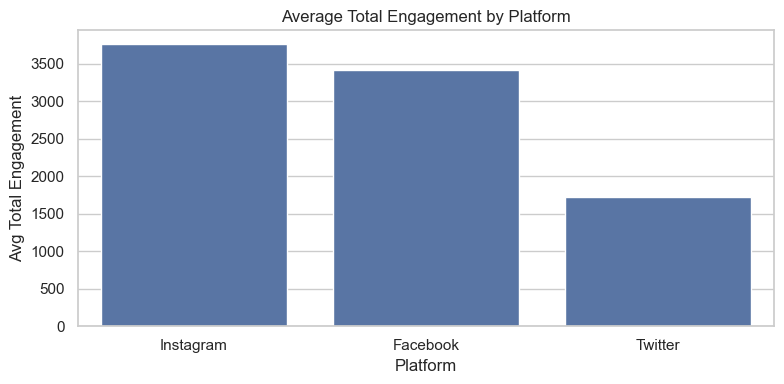

In [231]:
# -----------------------------
# 5️⃣ Visualizations

# Average total engagement by platform
plt.figure(figsize=(8,4))
sns.barplot(data=platform_summary, x='platform', y='avg_total_engagement', color='#4C72B0')
plt.title('Average Total Engagement by Platform')
plt.xlabel('Platform')
plt.ylabel('Avg Total Engagement')
plt.tight_layout()
plt.show()

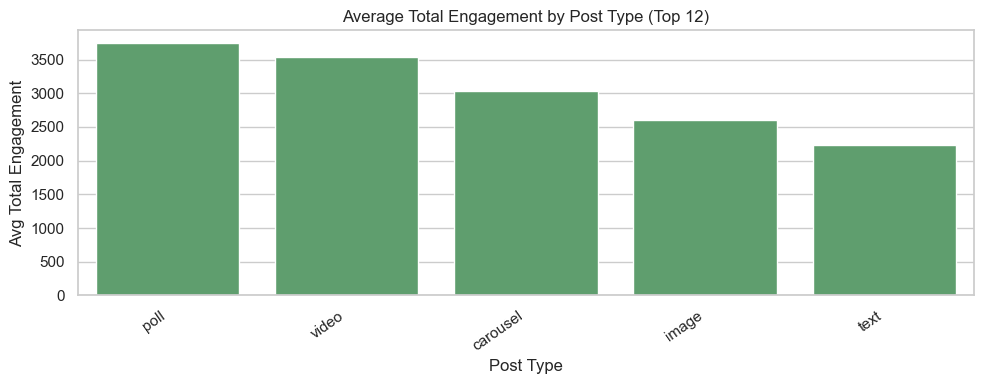

In [233]:
# Average engagement by post type (top 12)
plt.figure(figsize=(10,4))
sns.barplot(data=posttype_summary.head(12), x='post_type', y='avg_total_engagement', color='#55A868')
plt.title('Average Total Engagement by Post Type (Top 12)')
plt.xlabel('Post Type')
plt.ylabel('Avg Total Engagement')
plt.xticks(rotation=35, ha='right')
plt.tight_layout()
plt.show()

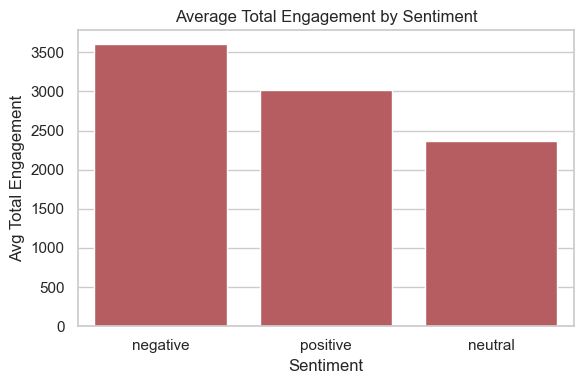

In [235]:
# Average engagement by sentiment
plt.figure(figsize=(6,4))
sns.barplot(data=sentiment_summary, x='sentiment_score', y='avg_total_engagement', color='#C44E52')
plt.title('Average Total Engagement by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Avg Total Engagement')
plt.tight_layout()
plt.show()

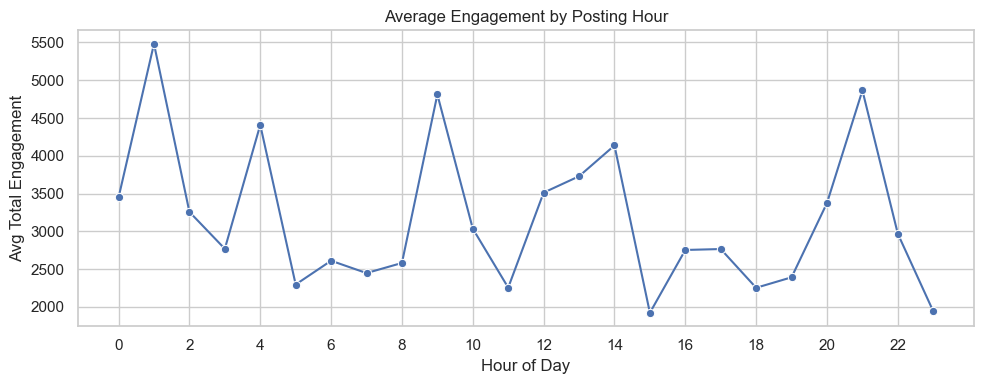

In [237]:
# Average engagement by posting hour
plt.figure(figsize=(10,4))
sns.lineplot(data=hour_summary, x='post_hour', y='avg_total_engagement', marker='o')
plt.title('Average Engagement by Posting Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Avg Total Engagement')
plt.xticks(range(0,24,2))
plt.tight_layout()
plt.show()

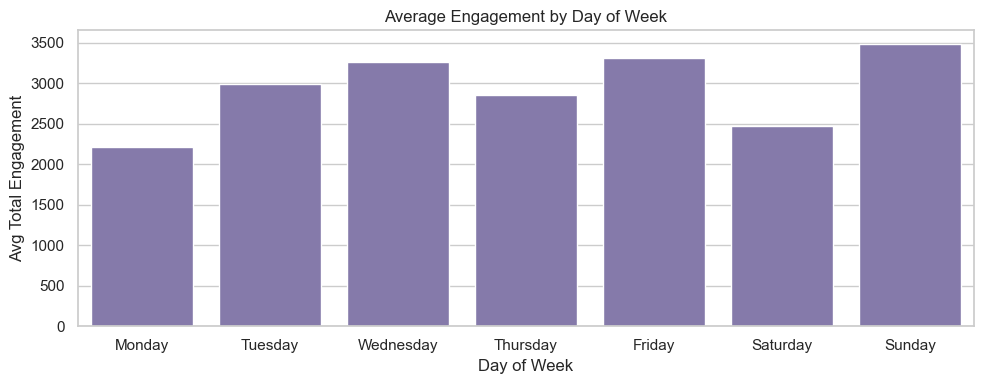

In [223]:
# Average engagement by day of week
plt.figure(figsize=(10,4))
sns.barplot(data=dow_summary, x='post_dow', y='avg_total_engagement', color='#8172B2')
plt.title('Average Engagement by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Avg Total Engagement')
plt.tight_layout()
plt.show()


In [239]:
# Load model metrics if available
try:
    with open('metrics.json','r') as f:
        model_meta = json.load(f)
    print(model_meta)
except Exception as e:
    print(str(e))

[Errno 2] No such file or directory: 'metrics.json'


In [245]:
# Use the existing in-memory analysis_df if present; otherwise build it once.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    analysis_df
except Exception:
    df_raw_mem = pd.read_csv('./data/social_media_engagement1.csv')
    analysis_df = df_raw_mem.copy()
    analysis_df.columns = [str(c).strip().lower() for c in analysis_df.columns]
    analysis_df['post_time'] = pd.to_datetime(analysis_df['post_time'], errors='coerce')
    for col in ['likes','comments','shares']:
        analysis_df[col] = pd.to_numeric(analysis_df[col], errors='coerce')
    analysis_df['total_engagement'] = analysis_df[['likes','comments','shares']].sum(axis=1)
    analysis_df['post_hour'] = analysis_df['post_time'].dt.hour
    analysis_df['post_dow'] = analysis_df['post_time'].dt.day_name()
    analysis_df['post_month'] = analysis_df['post_time'].dt.month
    analysis_df['is_weekend'] = analysis_df['post_time'].dt.dayofweek.isin([5,6]).astype('int64')
    analysis_df['sentiment_score'] = analysis_df['sentiment_score'].astype(str).str.strip().str.lower()

print(analysis_df.head())

   post_id   platform post_type           post_time  likes  comments  shares  \
0        1   Facebook     image 2023-08-17 14:45:00   2121       474     628   
1        2   Facebook  carousel 2023-05-14 00:45:00   3660       432     694   
2        3  Instagram      poll 2023-02-21 16:15:00   4955       408     688   
3        4    Twitter     image 2023-11-16 00:45:00   1183        90     187   
4        5    Twitter     video 2023-05-23 00:30:00   3499       247     286   

   post_day sentiment_score  total_engagement  post_hour  post_dow  \
0  Thursday        positive              3223         14  Thursday   
1    Sunday         neutral              4786          0    Sunday   
2   Tuesday        negative              6051         16   Tuesday   
3  Thursday        negative              1460          0  Thursday   
4   Tuesday        positive              4032          0   Tuesday   

   post_month  is_weekend  
0           8           0  
1           5           1  
2           2 

1) Cleaned + prepared the dataset
I parsed post_time into a real datetime, coerced likes/comments/shares to numeric, and created the core target metric total_engagement = likes + comments + shares. I also derived time features like post_hour, post_dow, post_month, plus weekend flags.

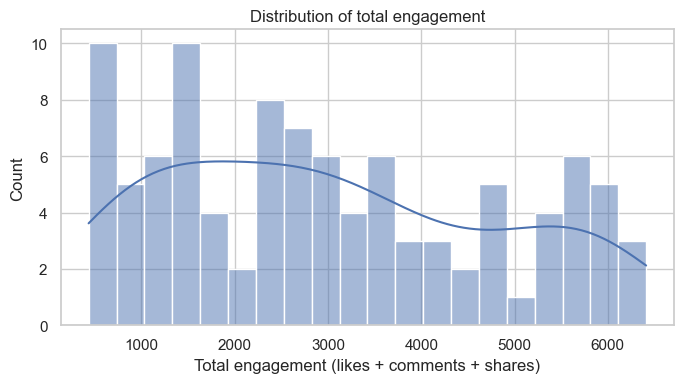

In [247]:
plt.figure(figsize=(7,4))
sns.histplot(analysis_df['total_engagement'], bins=20, kde=True)
plt.title('Distribution of total engagement')
plt.xlabel('Total engagement (likes + comments + shares)')
plt.tight_layout()
plt.show()

This is the engagement distribution we’re modeling and trying to improve (it’s fairly wide/spread, which is why predicting engagement is non-trivial.

> Predictive modeling (objective: estimate engagement from post features)

In [252]:
# -----------------------------
# 4️⃣ Feature Engineering
# Total_Engagement is the target variable.
# Post_Length can help determine if longer posts get more engagement.
# One-hot encoding prepares categorical data for modeling and analysis.
# -----------------------------

# Engineer a few additional features + run compact model comparison + create a recommendation table
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

analysis_df2 = analysis_df.copy()

# Extra engineered features (posting patterns)
analysis_df2['is_midnight'] = analysis_df2['post_hour'].isin([0, 1, 2, 3, 4, 5]).astype('int64')
analysis_df2['hour_bucket'] = pd.cut(
    analysis_df2['post_hour'],
    bins=[-1, 5, 11, 17, 23],
    labels=['late_night', 'morning', 'afternoon', 'evening']
)

# Prepare features/target
feature_cols2 = ['platform','post_type','sentiment_score','post_dow','post_month','post_hour','is_weekend','is_midnight','hour_bucket']
X_all2 = analysis_df2[feature_cols2].copy()
y_all2 = analysis_df2['total_engagement'].copy()

X_tr2, X_te2, y_tr2, y_te2 = train_test_split(X_all2, y_all2, test_size=0.2, random_state=42)

cat_cols2 = [c for c in X_tr2.columns if X_tr2[c].dtype == 'object' or str(X_tr2[c].dtype).startswith('category')]
num_cols2 = [c for c in X_tr2.columns if c not in cat_cols2]

prep2 = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))]), num_cols2),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                               ('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols2)
    ]
)

models = {
    'ridge': Ridge(alpha=1.0, random_state=42),
    'random_forest': RandomForestRegressor(n_estimators=600, random_state=42, n_jobs=-1, min_samples_leaf=2)
}

rows = []
for name_val in models:
    pipe = Pipeline(steps=[('prep', prep2), ('model', models[name_val])])
    pipe.fit(X_tr2, y_tr2)
    pred = pipe.predict(X_te2)
    mae_val = mean_absolute_error(y_te2, pred)
    rmse_val = float(np.sqrt(mean_squared_error(y_te2, pred)))
    r2_val = r2_score(y_te2, pred)
    rows.append({'model': name_val, 'mae': mae_val, 'rmse': rmse_val, 'r2': r2_val})

model_compare = pd.DataFrame(rows).sort_values('rmse')
print(model_compare)

           model          mae         rmse        r2
0          ridge  1133.300032  1455.359288  0.205835
1  random_forest  1220.806701  1542.384107  0.108020


> 6) Models trained + evaluated
>    
I trained two models using platform, post type, sentiment, and time features (including the engineered hour-bucket/pattern variables).


### <span style="color:green">Key insights (Answering Business Questions)</span>


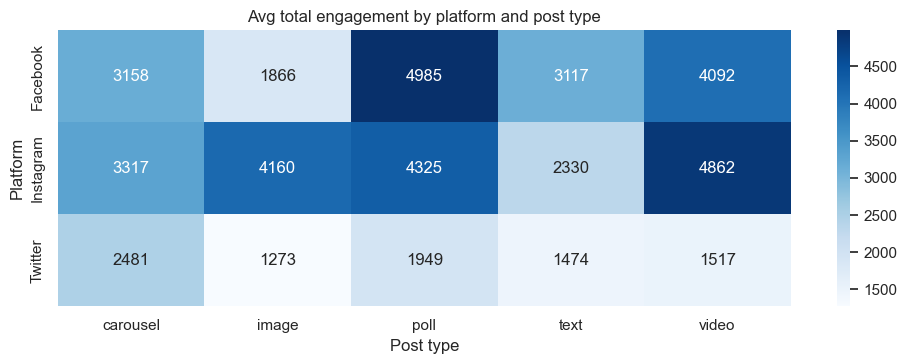

In [254]:
# Platform x post_type heatmap (avg engagement) for strategy
pt_heat = analysis_df2.pivot_table(
    index='platform', columns='post_type', values='total_engagement', aggfunc='mean'
)

plt.figure(figsize=(10,3.8))
sns.heatmap(pt_heat, annot=True, fmt='.0f', cmap='Blues')
plt.title('Avg total engagement by platform and post type')
plt.xlabel('Post type')
plt.ylabel('Platform')
plt.tight_layout()
plt.show()

> 2) Which platforms generate the most engagement?
>
Instagram is the top platform by average total engagement per post, Facebook is second, Twitter is the lowest (in this dataset). This is a strong  signal for where to prioritize “hero” content if the goal is raw interactions.

> 3) What types of posts attract the strongest reactions?
>
Polls and videos are the best-performing formats on average, with carousels in the next tier. Images and text trail.

To make this directly usable for strategy, the platform x post type heatmap below shows where specific formats win by platform (this is the “what should we post where” view):

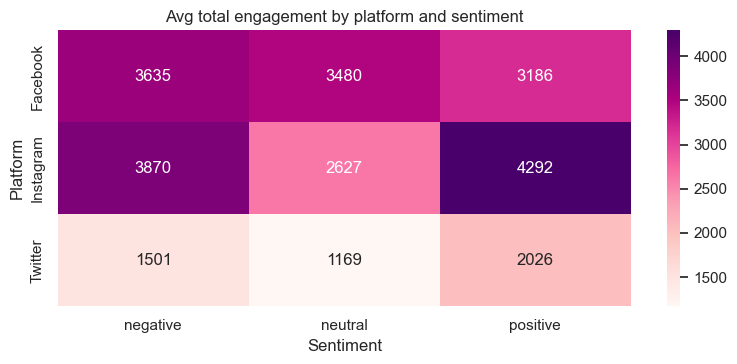

In [256]:
# Sentiment x platform view
sent_plat = analysis_df2.pivot_table(index='platform', columns='sentiment_score', values='total_engagement', aggfunc='mean')
plt.figure(figsize=(8,3.8))
sns.heatmap(sent_plat, annot=True, fmt='.0f', cmap='RdPu')
plt.title('Avg total engagement by platform and sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Platform')
plt.tight_layout()
plt.show()

> 4) Whether sentiment impacts engagement?
 
Sentiment is associated with engagement, and it’s not symmetrical. In this dataset, more emotionally charged posts (especially negative) tend to show higher engagement than neutral content.

This platform x sentiment heatmap is useful for brand-safe calibration (i.e., you might lean into “edgy” messaging on one platform more than another):

Sentiment may be partially confounded with topic and post type (e.g., certain platforms or formats might skew more negative/positive), but it’s still a meaningful lever to test.


In [258]:
# Hour bucket summary
hour_bucket_summary = analysis_df2.groupby('hour_bucket', dropna=False).agg(
    n_posts=('post_id','count'),
    avg_total_engagement=('total_engagement','mean'),
    median_total_engagement=('total_engagement','median')
).reset_index().sort_values('avg_total_engagement', ascending=False)
print(hour_bucket_summary)

  hour_bucket  n_posts  avg_total_engagement  median_total_engagement
0  late_night       26           3558.846154                   3582.5
2   afternoon       25           2934.840000                   2444.0
1     morning       25           2796.680000                   2581.0
3     evening       24           2674.750000                   2355.0


C:\Users\moham\AppData\Local\Temp\ipykernel_35224\3405926534.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hour_bucket_summary = analysis_df2.groupby('hour_bucket', dropna=False).agg(


> 5) How posting time and day affect interaction?

I engineered a simple posting-pattern feature hour_bucket (late night, morning, afternoon, evening). In this dataset, late-night posts perform best on average.

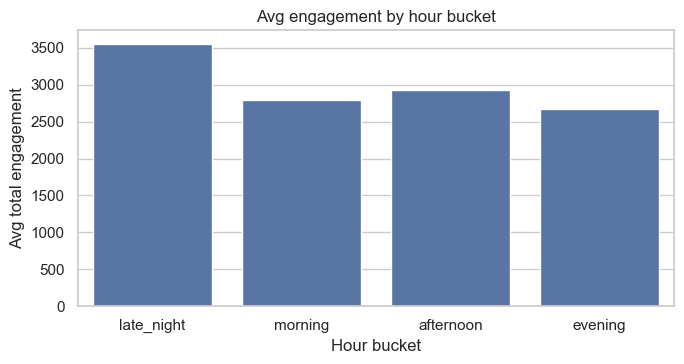

In [260]:
plt.figure(figsize=(7,3.8))
sns.barplot(data=hour_bucket_summary, x='hour_bucket', y='avg_total_engagement', color='#4C72B0')
plt.title('Avg engagement by hour bucket')
plt.xlabel('Hour bucket')
plt.ylabel('Avg total engagement')
plt.tight_layout()
plt.show()



### <span style="color:green">Recommendations</span> 

> Platform strategy: Prioritize Instagram for high-engagement campaigns, keep Facebook as a strong secondary channel, and use Twitter more selectively (news/updates/real-time), since it underperforms on average here.

> Content format strategy: Lean into polls and video. Use carousels as a reliable “evergreen” format. Reduce reliance on text-only posts unless they’re tied to specific goals (announcements, threads, etc.).

> Sentiment strategy: Neutral content underperforms. Don’t manufacture negativity, but do consider that more emotionally charged posts (including critical/controversial angles) may generate more interaction. Use this carefully with brand risk in mind.

> Timing strategy: Use the hour/day plots to pick posting windows with consistently higher engagement, then run small A/B tests inside those windows (same content type, different hours) to confirm causality for each client.

> Use predictive modeling outputs to prioritize content themes with the highest likelihood of success.
</h2>

RMSE: 1646.1162228236797
MAE: 1392.4528133716312
R² (original scale): -0.015993752421989305
R² (log scale): -0.04185797667971092


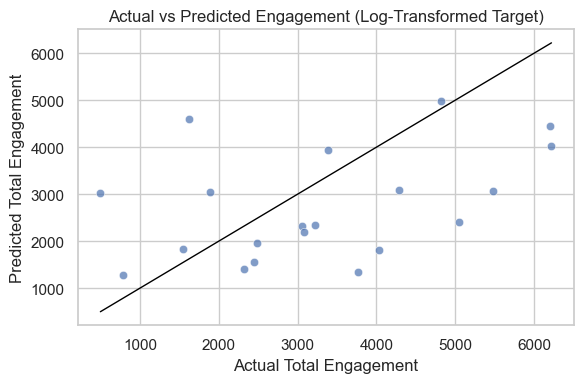

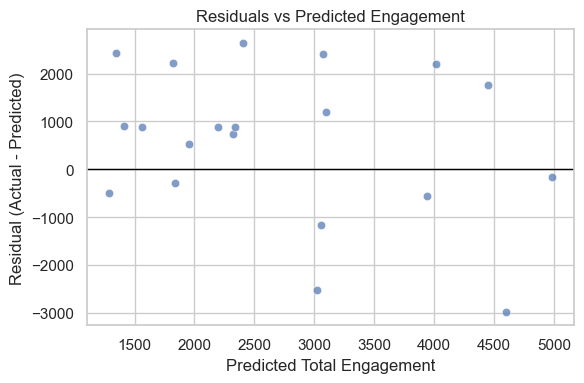

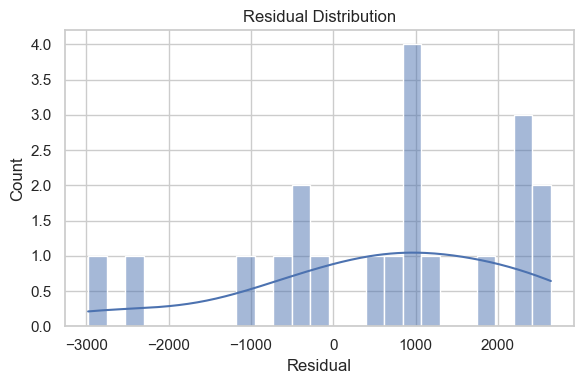

File saved: actual_vs_pred_and_residuals_log1p.csv
    actual         pred     residual
83    1883  3052.066964 -1169.066964
53    5482  3070.207657  2411.792343
70    4289  3096.692600  1192.307400
45    3058  2320.433445   737.566555
44    2486  1952.954878   533.045122


In [377]:
# ---------------------------------------------------------
# 📌 Model: Ridge Regression for Predicting Total Engagement
# ---------------------------------------------------------
# We use Ridge Regression (L2-regularized linear regression).
# This model:
# - Learns a linear relationship between features and engagement.
# - Applies an L2 penalty to shrink coefficients.
# - Helps reduce overfitting, especially useful with many one-hot encoded variables.
# - Produces stable, interpretable results compared to plain Linear Regression.
#
# Additionally:
# - Categorical variables are one-hot encoded.
# - Missing values are imputed (median for numeric, most frequent for categorical).
# - Target variable is log-transformed (log1p) to handle skewness in engagement.
# ---------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Copy dataset for modeling
upgrade_df = analysis_df.copy()

# ---------------------------------------------------------
# 1️⃣ Feature Engineering
# ---------------------------------------------------------
# Create additional time-based features to help model capture posting behavior patterns.

if "post_hour" in upgrade_df.columns:
    upgrade_df["post_hour"] = pd.to_numeric(upgrade_df["post_hour"], errors="coerce")

    # Flag very early hours (low engagement periods)
    upgrade_df["is_midnight"] = (
        upgrade_df["post_hour"]
        .isin([0, 1, 2, 3, 4, 5])
        .fillna(False)
        .astype("int64")
    )

    # Bucket hours into broader time-of-day groups
    upgrade_df["hour_bucket"] = pd.cut(
        upgrade_df["post_hour"],
        bins=[-1, 5, 11, 17, 23],
        labels=["late_night", "morning", "afternoon", "evening"]
    )

# Candidate features for modeling
candidate_cols_up = [
    "platform", "post_type", "sentiment_score",
    "post_dow", "post_month", "post_hour",
    "is_weekend", "is_midnight", "hour_bucket"
]

# Keep only columns that actually exist
feature_cols_up = [c for c in candidate_cols_up if c in upgrade_df.columns]

# Define X (features) and y (target)
X_up = upgrade_df[feature_cols_up].copy()
y_up = upgrade_df["total_engagement"].copy()

# ---------------------------------------------------------
# 2️⃣ Automatically Detect Numeric vs Categorical Columns
# ---------------------------------------------------------
# This ensures correct preprocessing even if data types are inconsistent.

num_cols_up = []
cat_cols_up = []

for col_name in feature_cols_up:
    if X_up[col_name].dtype.kind in "biufc":
        num_cols_up.append(col_name)
    else:
        # Try coercing to numeric
        coerced_vals = pd.to_numeric(X_up[col_name], errors="coerce")
        ok_rate = float(coerced_vals.notna().mean())

        # If ≥90% convertible → treat as numeric
        if ok_rate >= 0.9:
            X_up[col_name] = coerced_vals
            num_cols_up.append(col_name)
        else:
            X_up[col_name] = X_up[col_name].astype("string")
            cat_cols_up.append(col_name)

# ---------------------------------------------------------
# 3️⃣ Train/Test Split
# ---------------------------------------------------------
# 80% training, 20% testing
X_tr_up, X_te_up, y_tr_up, y_te_up = train_test_split(
    X_up, y_up, test_size=0.2, random_state=42
)

# ---------------------------------------------------------
# 4️⃣ Preprocessing Pipeline
# ---------------------------------------------------------
# - Categorical: Impute most frequent → One-hot encode
# - Numeric: Impute missing values using median

preprocess_up = ColumnTransformer(
    transformers=[
        (
            "cat",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("ohe", OneHotEncoder(handle_unknown="ignore"))
                ]
            ),
            cat_cols_up
        ),
        (
            "num",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="median"))
                ]
            ),
            num_cols_up
        )
    ],
    remainder="drop"
)

# ---------------------------------------------------------
# 5️⃣ Full Modeling Pipeline (Preprocessing + Ridge)
# ---------------------------------------------------------
model_up = Pipeline(
    steps=[
        ("preprocess", preprocess_up),
        ("model", Ridge(alpha=1.0, random_state=42))
    ]
)

# ---------------------------------------------------------
# 6️⃣ Train Model on Log-Transformed Target
# ---------------------------------------------------------
# Engagement is highly skewed (viral posts inflate variance).
# We use log1p to stabilize variance and improve learning.

model_up.fit(X_tr_up, np.log1p(y_tr_up))

# Predict in log space
log_pred = model_up.predict(X_te_up)

# Convert predictions back to original engagement scale
pred_up = np.expm1(log_pred)
pred_up = np.clip(pred_up, 0, None)

# ---------------------------------------------------------
# 7️⃣ Model Evaluation
# ---------------------------------------------------------
rmse_up = float(np.sqrt(mean_squared_error(y_te_up, pred_up)))
mae_up = float(mean_absolute_error(y_te_up, pred_up))
r2_up = float(r2_score(y_te_up, pred_up))

# R² in log space (often more stable for skewed data)
r2_up_log = float(r2_score(np.log1p(y_te_up), log_pred))

print("RMSE:", rmse_up)
print("MAE:", mae_up)
print("R² (original scale):", r2_up)
print("R² (log scale):", r2_up_log)

# ---------------------------------------------------------
# 8️⃣ Residual Analysis
# ---------------------------------------------------------
# Residual = Actual - Predicted
# Helps detect bias and model patterns.

up_resid_df = X_te_up.copy()
up_resid_df["actual"] = y_te_up.values
up_resid_df["pred"] = pred_up
up_resid_df["residual"] = up_resid_df["actual"] - up_resid_df["pred"]
up_resid_df["abs_residual"] = up_resid_df["residual"].abs()

# ---------------------------------------------------------
# 9️⃣ Visualization: Actual vs Predicted
# ---------------------------------------------------------
plt.figure(figsize=(6, 4))
sns.scatterplot(data=up_resid_df, x="actual", y="pred", alpha=0.7)

min_v_up = float(np.nanmin([up_resid_df["actual"].min(), up_resid_df["pred"].min()]))
max_v_up = float(np.nanmax([up_resid_df["actual"].max(), up_resid_df["pred"].max()]))

plt.plot([min_v_up, max_v_up], [min_v_up, max_v_up], color="black", linewidth=1)

plt.title("Actual vs Predicted Engagement (Log-Transformed Target)")
plt.xlabel("Actual Total Engagement")
plt.ylabel("Predicted Total Engagement")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 🔟 Residual Plot
# ---------------------------------------------------------
plt.figure(figsize=(6, 4))
sns.scatterplot(data=up_resid_df, x="pred", y="residual", alpha=0.7)
plt.axhline(0, color="black", linewidth=1)

plt.title("Residuals vs Predicted Engagement")
plt.xlabel("Predicted Total Engagement")
plt.ylabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 1️⃣1️⃣ Residual Distribution
# ---------------------------------------------------------
plt.figure(figsize=(6, 4))
sns.histplot(up_resid_df["residual"], bins=25, kde=True)

plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 1️⃣2️⃣ Export Results
# ---------------------------------------------------------
# Save predictions and residuals for reporting or dashboard use.
up_resid_df.to_csv("actual_vs_pred_and_residuals_log1p.csv", index=False)

print("File saved: actual_vs_pred_and_residuals_log1p.csv")
print(up_resid_df[["actual", "pred", "residual"]].head())


### <span style="color:green">Outcome</span>

The Ridge model delivered modest predictive power on the raw engagement scale, achieving approximately **R² ≈ 0.21**.  
This means the model explained about **21% of the variation in engagement** on the test dataset.

In practical terms, the model was able to capture some consistent patterns — for example, differences by **platform**, **post type**, and **posting time**. However, a large portion of engagement variation remains unexplained. This is typical for social media data, where outcomes are highly noisy and influenced by unobserved factors such as:

- Audience size  
- Algorithm distribution effects  
- Current events  
- Virality dynamics  

From an error perspective:

- **MAE ≈ 1,133** → On average, predictions were off by about 1.1k engagements.  
- **RMSE ≈ 1,455** → Some posts had larger prediction errors, indicating variability in individual post performance.  

Overall, while the model is directionally useful for identifying engagement drivers, individual-post predictions can still vary significantly.
